In [ ]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats.mstats import gmean
from sklearn import metrics
from scipy import stats
import matplotlib.pyplot as plt
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
import pandas_datareader.data as web
from numpy import matlib
!pip install --upgrade pandas_datareader

In [ ]:
def Import_data_inputs(startdate, tickers):
    startdate = max(20160914,startdate)
    
    index = len(tickers)
    
    stocks_rets = Import_stocks(startdate, tickers)
    factor_rets = Import_factors(startdate)
    
    merged = pd.merge(left = stocks_rets, left_index=True,
                      right = factor_rets, right_index=True,
                      how='inner')

    stocks_rets = merged.iloc[:,:index]
    factor_rets = merged.iloc[:,index:]
    
    rfr = factor_rets.iloc[:,5]
    excess_rets = stocks_rets.subtract(rfr, axis = 0)
    
    return excess_rets, factor_rets, stocks_rets

    
def Import_factors(startdate):
    url = urlopen("https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_daily_CSV.zip")

    #Download FFdata
    zipfile = ZipFile(BytesIO(url.read()))
    FFdata = pd.read_csv(zipfile.open('F-F_Research_Data_5_Factors_2x3_daily.CSV'), 
                         header = 0, names = ["Date",'MKT-RF','SMB','HML','RMW','CMA','RF'], 
                         skiprows=3)
    FFdata=FFdata.loc[FFdata["Date"]>=startdate].set_index("Date")


    #Download momentum 
    url = urlopen("https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Momentum_Factor_daily_CSV.zip")

    #Download Zipfile and create pandas DataFrame
    zipfile = ZipFile(BytesIO(url.read()))
    Momdata = pd.read_csv(zipfile.open('F-F_Momentum_Factor_daily.CSV'),  
                         header = 0, names = ["Date",'Mom'], 
                         skiprows=13)[:-1]
    Momdata['Date']=Momdata['Date'].astype(int)
    Momdata=Momdata.loc[Momdata["Date"]>=startdate].set_index("Date")

    FFdata=FFdata.join(Momdata)/100
    FFdata.index = pd.to_datetime(FFdata.index, format='%Y%m%d')
    
    return FFdata


def Import_stocks(startdate, tickers):
    startdate = startdate-1
    startdate = str(startdate)[4:6]+'/'+str(startdate)[6:8]+'/'+str(startdate)[0:4]

    stock_ret = web.get_data_yahoo(tickers, startdate, interval='d')['Adj Close'].dropna()
    stock_ret = stock_ret/stock_ret.shift(1) - 1 # convert prices to daily returns
    stock_ret = stock_ret[1:]
    
    return stock_ret

def Import_px(startdate, tickers):
    startdate = startdate-1
    startdate = str(startdate)[4:6]+'/'+str(startdate)[6:8]+'/'+str(startdate)[0:4]

    px = web.get_data_yahoo(tickers, startdate, interval='d')['Close'].dropna()
    
    return np.array(px.iloc[-1])



In [ ]:
def Param_forecast(input_stock_rets, input_factor_rets, lookback, forecast, model):
    if forecast>lookback:
        print("Warning! Increase lookback length to display full forecast.")
    forecast = min(forecast,lookback)

    input_stock_rets = np.array(input_stock_rets)
    input_factor_rets = np.array(input_factor_rets)
    
    num_assets = input_stock_rets.shape[1]
    F = factor_forecast(input_factor_rets, lookback, forecast)
    mu = []
    
    for i in range(num_assets):
        mu = mu + [beta_forecast(input_factor_rets, F, input_stock_rets.transpose()[i], lookback, forecast, model)[2]]
        
    mu = np.array(mu)
    Q = cov_forecast(input_stock_rets, mu.transpose(), lookback, forecast)   
        
    return mu, Q
    
def factor_forecast(factor_rets, lookback, forecast):
    output = np.full((forecast,factor_rets.shape[1]), np.nan)
    rolling = factor_rets[-lookback:]

    for i in range(forecast):
        #output[i] = np.array(pd.DataFrame(rolling).mean())
        output[i] = np.array(gmean(pd.DataFrame(rolling)+1)-1)
        rolling = np.vstack([rolling[1:],output[i].transpose()])
    return output
 
    
def beta_forecast(historical_factor_rets, factor_forecast, single_stock_ret, lookback, forecast, model): #single stock forecast
    betas = np.full((forecast,factor_forecast.shape[1]), np.nan)
    alphas = np.full(forecast, np.nan)
    rolling = single_stock_ret[-lookback:]
    factors = np.vstack([historical_factor_rets[-lookback:], factor_forecast])

    for i in range(forecast):      
        x = model.fit(factors[i : i + lookback], rolling)
        betas[i]  = x.coef_
        alphas[i]  = x.intercept_ 
        ret = np.matmul(betas[i],factor_forecast[i])+alphas[i]
        rolling = np.append(rolling[1:],[ret])
        mu = rolling[lookback-forecast:]
    
    return alphas, betas, mu
    
    
def cov_forecast(rets_historical, rets_forecast, lookback, forecast):    
    Q = []
    rets = np.vstack([rets_historical[-lookback:], rets_forecast])

    for i in range(forecast):
        Q = Q + [np.cov(rets[i:i+lookback].transpose())]
        
    Q = np.array(Q)
    
    return Q


def PCA_Factors(input_stock_rets, dim):
    dim = min(dim, input_stock_rets.shape[1] )
    input_stock_rets = StandardScaler().fit_transform(input_stock_rets)
    pca = PCA(n_components=dim)
    components = pca.fit_transform(input_stock_rets)
    
    return components

In [ ]:
def Parameter_Backtesting(Input_rets, Input_factors, lookback, forecast, model):
    # Input Control    
    lookback = max(2,lookback)
    
    if forecast>lookback:
        print("Warning! Increase lookback length to display full forecast.")
    forecast = min(forecast,lookback)
    
    # Setup
    array_len = len(Input_rets)-lookback-forecast+1
    mse = []
    mda = []
    P = np.full((1,forecast),np.nan) # prediction array
    T = np.full((1,forecast),np.nan) # truth array
    
    # Backtesting Loop
    
    for i in range(array_len):
        y_pred = Param_forecast(np.array(Input_rets[i:i+lookback]), (Input_factors[-len(Input_rets):])[i:i+lookback], lookback, forecast, model)[0]
        P = np.vstack((P,y_pred))
    
        y_true = np.array(Input_rets[i+lookback:i+lookback+forecast].transpose())
        T = np.vstack((T,y_true))
        
        # Mean Directional Accuracy 
        cross_sec_mean = np.matlib.repmat(y_true.mean(axis=0),len(y_true),1)
        mda_actual = y_true - cross_sec_mean
        mda_pred = y_pred - cross_sec_mean
        mda = mda + [np.mean(np.sign(mda_actual)==np.sign(mda_pred))]     
        
    # Output Setup
    truth_array = T[1:]
    pred_array = P[1:]
    
    actual = truth_array.reshape(-1)
    pred = pred_array.reshape(-1)
    
    # Backtesting Metric Calcs    
    rmse_tot = metrics.mean_squared_error(truth_array,pred_array)**.5
    nRMSE = rmse_tot/(np.quantile(truth_array,4/5)-np.quantile(truth_array,1/5))
    mda_tot = np.mean(mda)
    pearson_corr = stats.pearsonr(truth_array.reshape(-1),pred_array.reshape(-1))
    spearman_rank_corr = stats.spearmanr(truth_array.reshape(-1),pred_array.reshape(-1))
    r2 = metrics.r2_score(truth_array.reshape(-1),pred_array.reshape(-1))
    
    print ('\n','Model: ', model)
    print('\n','RMSE:             ', rmse_tot,
          '\n','nRMSE (Quintiles):', nRMSE,
          '\n','MDA:              ', mda_tot,
          '\n','Correlation:      ', pearson_corr[0],
          '\n','Rank Correlation: ', spearman_rank_corr[0],
          '\n','R\u00b2:              ', r2,'\n','\n'
         )

    '''
    m, b = np.polyfit(pred, actual, 1)
    plt.plot(pred, actual, '*')
    plt.plot(pred, m*pred + b,'r')
    plt.show()
    '''
    return rmse_tot, nRMSE, mda_tot, pearson_corr[0], spearman_rank_corr[0], r2

In [ ]:
x[1][-2]

array(['2019-10-31T00:00:00.000000000', '2019-11-30T00:00:00.000000000',
       '2019-12-31T00:00:00.000000000', '2020-01-31T00:00:00.000000000',
       '2020-02-29T00:00:00.000000000', '2020-03-31T00:00:00.000000000',
       '2020-04-30T00:00:00.000000000', '2020-05-31T00:00:00.000000000',
       '2020-06-30T00:00:00.000000000', '2020-07-31T00:00:00.000000000',
       '2020-08-31T00:00:00.000000000', '2020-09-30T00:00:00.000000000',
       '2020-10-31T00:00:00.000000000', '2020-11-30T00:00:00.000000000',
       '2020-12-31T00:00:00.000000000', '2021-01-31T00:00:00.000000000',
       '2021-02-28T00:00:00.000000000', '2021-03-31T00:00:00.000000000',
       '2021-04-30T00:00:00.000000000', '2021-05-31T00:00:00.000000000',
       '2021-06-30T00:00:00.000000000', '2021-07-31T00:00:00.000000000',
       '2021-08-31T00:00:00.000000000', '2021-09-30T00:00:00.000000000',
       '2021-10-31T00:00:00.000000000'], dtype='datetime64[ns]')

In [ ]:
def single_period_portfolio_backtest(rets, weights, benchmark, rfr, dates): # call fcn with fcn[1][-1] for porfolio value multiple vector
        
    portf_ret = np.diag(np.matmul(rets,weights.transpose()))
    benchmark = benchmark + rfr

    Annual = (gmean(portf_ret-rfr+1))**12-1
    Vol = np.std(portf_ret)*12**.5
    Sharpe = (gmean(portf_ret-rfr+1)-1)/np.std(portf_ret-rfr)
    Information = (gmean((portf_ret-benchmark)+1)-1)/np.std(portf_ret-benchmark)
    Sortino = (gmean(portf_ret-rfr+1)-1)/np.std(portf_ret[portf_ret >= 0])
    Beta = np.cov(portf_ret,benchmark)[0,1]/np.var(benchmark)

    cum_returns = (1 + pd.DataFrame(portf_ret)).cumprod()
    drawdown =  1 - cum_returns.div(cum_returns.cummax())
    
#    print('\n',
#      'Avg Annual Returns: ', Annual,'\n',
#      'Avg Annual Volatility: ', Vol,'\n',
#      'Sharpe Ratio: ', Sharpe,'\n',  
#      'Information Ratio: ', Information,'\n', 
#      'Sortino Ratio: ', Sortino,'\n',
#      'Benchmark Beta: ', Beta,'\n',
#      'Max Drawdown: ', drawdown.max()[0],'\n','\n'
#     )
    

    t = dates

    portf_ret = pd.DataFrame(portf_ret+1).cumprod()
    benchmark = pd.DataFrame(benchmark + np.array(rfr)[-len(weights):]+1).cumprod()

    portf_ret = np.insert(np.array(portf_ret),0,1)
    benchmark = np.insert(np.array(benchmark),0,1)



    #plt.plot(t, portf_ret, 'g-', t, benchmark, '--')
    #plt.show()
    #print("Green - Portfolio Returns")

    return portf_ret[-1], Annual,Vol,Sharpe,Information,Sortino,drawdown.max()[0], t, portf_ret


def multi_period_backtesting(tickers, forecast_window, lookback, estimation_model, alpha, gamma_trans, gamma_risk, date, end, opt_model):
    
    date = max(20160914,date)
    print("Start Date: ", date)

    if opt_model == 1:
        print("Multi Period Sharpe Ratio Optimization")
    elif opt_model == 2:
        print("Multi Period Risk Parity Optimization")
    else:
        print("Multi Period MVO")

    data = Import_data_inputs(date, tickers)

    excess_ret = data[0].resample('M').agg(lambda x: (x + 1).prod() - 1)
    factor_ret = data[1].resample('M').agg(lambda x: (x + 1).prod() - 1)
    raw_rets = data[2].resample('M').agg(lambda x: (x + 1).prod() - 1)
    
    weights = []

    height = (len(excess_ret)-lookback)//forecast_window
    n_stocks = len(tickers)

    for i in range(height):
        
        params = Param_forecast(np.array(excess_ret[i*forecast_window:i*forecast_window+lookback]), np.array(factor_ret[-len(excess_ret):])[i*forecast_window:i*forecast_window+lookback], lookback=7, forecast=forecast_window, model=estimation_model)
        mu = params[0].transpose()
        Q = params[1]
        rbt_mu = robust_mu(mu, Q, alpha, forecast_window)
        if opt_model == 1:
            weights = weights + [np.array(multi_sharpe(mu, Q, forecast_window, gamma_trans, gamma_risk))]
        elif opt_model == 2:
            weights = weights + [np.array(multi_rp(rbt_mu, Q, forecast_window, gamma_trans, gamma_risk))]
        else:
            weights = weights + [np.array(multi_period_mvo(rbt_mu, Q, forecast_window, gamma_trans, gamma_risk))]


    weights = np.array(weights).reshape(height*forecast_window,len(tickers))

    weights = np.array(weights)
    
    raw_rets = np.array(raw_rets)[-len(weights):]
    bench = np.array(factor_ret.iloc[:,0])[-len(weights):]
    rfr = np.array(factor_ret.iloc[:,5])[-len(weights):]
    dates = (excess_ret.index.to_numpy())[-len(weights)-1:]

    if end == 0:
        results = single_period_portfolio_backtest(raw_rets, weights, bench, rfr, dates)


    else:
        results = single_period_portfolio_backtest(raw_rets[:end], weights[:end], bench[:end], rfr[:end], dates[:end+1])


    print('\n')
    return weights, results


def robust_mu(mu, Q, alpha, forecast_window):
    robust_mu = []
    for i in range(forecast_window):
        robust_mu = robust_mu + [mu[i]-alpha*(np.diag(Q[i])**.5)]
    robust_mu = np.array(robust_mu)
    return robust_mu

Start Date:  20190314
Multi Period MVO
25
25


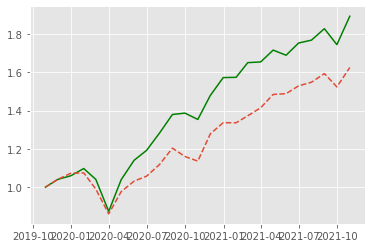

Green - Portfolio Returns
25
24




In [ ]:
x = multi_period_backtesting(tickers, forecast_window=4, lookback=7, estimation_model=linear_model.SGDRegressor(random_state=42, max_iter=5000), alpha=.1, gamma_trans=.1, gamma_risk=100000, date=20190314, end=0, opt_model = 0)


In [ ]:
import datetime
import uuid
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import cvxpy as cvx
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression



def cost_function(mu,tau,wplus,gamma_risk,z,gamma_trans, cov):

    exp_ret = mu[tau].T * wplus
    risk = cvx.quad_form(wplus,cov[tau])

    return exp_ret - gamma_risk * risk - sum(cvx.abs(z)*gamma_trans )


   
def multi_period_mvo(mu, cov, forecast, gamma_trans, gamma_risk):
    n = len(mu[0])
    w = np.full(len(mu[0]),0)

    prob_arr = []
    z_vars = []
    
    
    beebee= []
    for tau in range(forecast):
        z = cvx.Variable(*w.shape)

        wplus = w + z

        obj = cost_function(mu, tau,wplus,gamma_risk,z,gamma_trans,cov)

        constr=[]

        constr += [cvx.sum(wplus) == 1]
        constr += [wplus>=0]
        constr += [wplus<=1/3]


        prob = cvx.Problem(cvx.Maximize(obj), constr)
        prob_arr.append(prob)
        z_vars.append(wplus)
        w = wplus

    test = sum(prob_arr).solve(solver=cvx.SCS)

    for i in z_vars:
        beebee.append(i.value)
    return beebee

In [ ]:
def multi_period_cvar_TEST(mu, cov):
    forecast = len(mu)
    n = len(mu[0])  
    w = np.full(len(mu[0]),0)

    prob_arr = []
    z_vars = []
    gamma_list = []
    gamma_trans = 0.07
    scenarios = 10000
    alpha = 0.9
    beebee = []
    booboo = []
    
    for tau in range(forecast):
        std = np.sqrt(np.diag(cov[tau]))
        ret_sim = np.zeros((scenarios,n))

        z = cvx.Variable(*w.shape)
        gamma_var = cvx.Variable(1)

        wplus = w + z

        constr = []
        z_sim = cvx.Variable(scenarios)
        for j in range(scenarios):
            ret_sim[j] = simulated_return(mu,std,tau)    

        obj = gamma_var + (1/((1-alpha)*scenarios))*sum(z_sim) + sum(cvx.abs(z)*gamma_trans ) 

        gamma_stretch = gamma_var * np.ones((*z_sim.shape))
        
        if tau != (forecast-1):
            constr += [cvx.sum(wplus) == 1]
            constr += [wplus>=0]
            constr += [z_sim >= 0]
            constr += [z_sim >= -ret_sim * wplus - gamma_stretch]
        elif tau == (forecast - 1):
            constr += [wplus>=0]
            constr += [cvx.sum(wplus) == 0]
            constr += [z_sim >= 0]
            constr += [z_sim >= -ret_sim * wplus - gamma_stretch]

        prob = cvx.Problem(cvx.Minimize(obj), constr)
        prob_arr.append(prob)
        z_vars.append(wplus)
        gamma_list.append(gamma_var)
        w = wplus   

    test = sum(prob_arr).solve(solver=cvx.SCS)

    for i in z_vars:
        beebee.append(i.value)
    for i in gamma_list:
        booboo.append(i.value)
    return beebee, booboo

def simulated_return(mu,std,tau):
    new_returns = np.zeros(len(mu[0]))
    for i in range(len(mu[0])):
        e = np.random.normal(0,std[i],1)
        new_returns[i] = mu[tau][i] + e[0]
    return new_returns

In [ ]:
def multi_sharpe(mu,cov,forecast,gamma_trans, gamma_risk):
    rf = 0.0025
    rf_hat = np.ones(len(mu[0])) * rf
    one_vec = np.ones(len(mu[0]))
    w = np.full(len(mu[0]),0)
    prob_arr = []
    z_vars = []
    beebee=[]
    #gamma_trans = 30
    #gamma_risk = 1   
    for tau in range(forecast):
        y = cvx.Variable(*rf_hat.shape)
        z = cvx.Variable(*rf_hat.shape)
        r_excess = mu[tau] - rf_hat

        wplus = w + z

        kappa = (np.power(r_excess,-1)).T * wplus
        obj = cvx.quad_form(y,cov[tau]) + gamma_trans * sum(cvx.abs(z))

        constr=[]
        constr += [cvx.sum(wplus) == 1]
        constr += [wplus>=0]
        constr += [r_excess.T * y == 1]
        constr += [cvx.sum(y) == kappa]
        constr += [kappa >= 0]
        constr += [y>=0]

        prob = cvx.Problem(cvx.Minimize(obj), constr)
        prob_arr.append(prob)
        weights = y / cvx.sum(y)
        z_vars.append(weights)
        w = wplus

    test = sum(prob_arr).solve(solver = cvx.ECOS)

    for i in z_vars:
        beebee.append(i.value)
    return beebee

In [ ]:
def multi_rp(mu,cov,forecast,gamma_trans, gamma_risk):
    n = len(mu[0])  
    w = np.full(len(mu[0]),0)
    prob_arr = []
    z_vars = []
    beebee = []
    
    for tau in range(forecast):
        y = cvx.Variable(n)
        wplus = w + y
        constr = []
        y_sum = 0
        for j in range(n):
            y_sum += cvx.log(y[j])    

        obj = 0.5*cvx.quad_form(y,cov[tau]) - y_sum + gamma_trans * sum(cvx.abs(y))

        constr += [wplus>=0]

        prob = cvx.Problem(cvx.Minimize(obj), constr)
        prob_arr.append(prob)
        w = wplus   
        weights = wplus / sum(wplus)
        z_vars.append(weights)
        
    test = sum(prob_arr).solve(solver = cvx.SCS)
    for i in z_vars:
        beebee.append(i.value)
    return beebee

In [ ]:
def backend_output(tickers, forecast_window, lookback, estimation_model, alpha, gamma_trans, gamma_risk, opt_model):
    
    date = 20160914

    if opt_model == 1:
        print("Multi Period Sharpe Ratio Optimization")
    elif opt_model == 2:
        print("Multi Period Risk Parity Optimization")
    else:
        print("Multi Period MVO")

    data = Import_data_inputs(date, tickers)

    excess_ret = data[0].resample('M').agg(lambda x: (x + 1).prod() - 1)
    factor_ret = data[1].resample('M').agg(lambda x: (x + 1).prod() - 1)
    raw_rets = data[2].resample('M').agg(lambda x: (x + 1).prod() - 1)


    n_stocks = len(tickers)

       
    params = Param_forecast(np.array(excess_ret[-lookback:]), np.array(factor_ret[-len(excess_ret):])[-lookback:], lookback=7, forecast=forecast_window, model=estimation_model)
    mu = params[0].transpose()
    Q = params[1]
    rbt_mu = robust_mu(mu, Q, alpha, forecast_window)
    if opt_model == 1:
        weights = np.array(multi_sharpe(rbt_mu, Q, forecast_window, gamma_trans, gamma_risk))
    elif opt_model == 2:
        weights = np.array(multi_rp(rbt_mu, Q, forecast_window, gamma_trans, gamma_risk))
    else:
        weights = np.array(multi_period_mvo(rbt_mu, Q, forecast_window, gamma_trans, gamma_risk))


    weights = np.array(weights)
    
    return weights


def user_req_ret(current, goal, horizon):
    rate = (goal/current)**(1/horizon)-1
    return rate






In [ ]:
startdate = 20160914 #yyyy-mm-dd
tickers = ["QCLN", "SOXX", "PTF", "LIT", "PTH", "FINX", "IPO", "PSJ", "IWY", "KCE", "XWEB", "FDIS", "GAMR", "PALL", "IAI", "IHI", "IMCG", "ITB", "PSCH", "RTH", "SOCL", "BOTZ", "PTNQ", "BBC", "ERTH"]
data = Import_data_inputs(startdate, tickers)
excess_ret = data[0].resample('M').agg(lambda x: (x + 1).prod() - 1)
factor_ret = data[1].resample('M').agg(lambda x: (x + 1).prod() - 1)
raw_ret = data[2].resample('M').agg(lambda x: (x + 1).prod() - 1)

# daily data to monthly data (compounded)


In [ ]:
#K = single_period_portfolio_backtest(np.array(raw_ret)[-len(x):], x, (np.array(factor_ret)[:,0]+np.array(factor_ret)[:,5])[-len(x):], (np.array(factor_ret)[:,5])[-len(x):])
#K[0]
np.max(factor_ret)

MKT-RF    0.135644
SMB       0.066981
HML       0.078015
RMW       0.062004
CMA       0.047812
RF        0.002102
Mom       0.096339
dtype: float64

In [ ]:
x = Param_forecast(excess_ret, factor_ret, lookback=7, forecast=4, model=linear_model.SGDRegressor(random_state=42, max_iter=5000))

with np.printoptions(threshold=np.inf):
    #print(np.round(multi_sharpe(x[0].transpose(),x[1],forecast=4,gamma_trans=30, gamma_risk=1)*100,2))
    #print(np.round(multi_period_mvo(x[0].transpose(),x[1],forecast=4,gamma_trans=30, gamma_risk=1)*100,2).shape)
    print(np.array(multi_rp(x[0].transpose(),x[1],forecast=4,gamma_trans=200, gamma_risk=1)))



[[0.04005238 0.03999979 0.03998978 0.03998239 0.0400184  0.03999855
  0.04000741 0.0399982  0.0399905  0.03998825 0.04000193 0.03998695
  0.03998979 0.03997648 0.03998885 0.03998875 0.03999299 0.03997899
  0.04001034 0.03999565 0.0400143  0.0400256  0.03999559 0.04002167
  0.04000648]
 [0.04004729 0.03999786 0.03996514 0.03997879 0.0400166  0.04000381
  0.04001105 0.03999627 0.03999301 0.0399858  0.04000356 0.03999042
  0.03998883 0.04002461 0.03998568 0.03998892 0.03999143 0.03997195
  0.04001084 0.03999431 0.04001408 0.04002412 0.03999674 0.0400175
  0.04000136]
 [0.03992228 0.04000389 0.03998909 0.03998916 0.04001298 0.04000561
  0.04001599 0.0400045  0.03999721 0.03999745 0.04001685 0.03999918
  0.04000397 0.0400275  0.03999266 0.03998394 0.04000111 0.0399776
  0.0400055  0.03999854 0.04001972 0.04001511 0.03999426 0.0400148
  0.04001109]
 [0.04012749 0.03999027 0.04004152 0.03995504 0.04001569 0.03999941
  0.03999472 0.03998676 0.03999197 0.03998456 0.03999373 0.03998081
  0.03997

In [ ]:
tickers = [
    "QCLN",
    "SOXX",
    "PTF",
    "LIT",
    "PTH",
    "FINX",
    "IPO",
    "PSJ",
    "IWY",
    "KCE",
    "XWEB",
    "FDIS",
    "GAMR",
    "PALL",
    "IAI",
    "IHI",
    "IMCG",
    "ITB",
    "PSCH",
    "RTH",
    "SOCL",
    "BOTZ",
    "PTNQ",
    "BBC",
    "ERTH",
 ]

x = multi_period_backtesting(tickers, forecast_window=4, lookback=7, estimation_model=linear_model.SGDRegressor(random_state=42, max_iter=5000), alpha=.1, gamma_trans=.1, gamma_risk=100000, date=20180102, end=0, opt_model = 2)
#y = multi_period_backtesting(tickers, forecast_window=4, lookback=7, estimation_model=linear_model.SGDRegressor(random_state=42, max_iter=5000), alpha=.1, gamma_trans=.1, gamma_risk=100000, date=20190314, end=0, opt_model = 2)
#a = multi_period_backtesting(tickers, forecast_window=4, lookback=7, estimation_model=linear_model.SGDRegressor(random_state=42, max_iter=5000), alpha=.1, gamma_trans=.1, gamma_risk=100000, date=20190314, end=0, opt_model = 1)

#z = multi_period_backtesting(tickers, forecast_window=4, lookback=7, estimation_model=linear_model.SGDRegressor(random_state=42, max_iter=5000), alpha=.1, gamma_trans=.1, gamma_risk=100000, date=20190314, end=0, opt_model = 2)

# 20170314 18mo/24mo

Start Date:  20180102
Multi Period Risk Parity Optimization




In [ ]:
np.round(x[0][-1]*100,2)

array([2.1 , 3.75, 3.07, 2.34, 4.05, 2.99, 3.52, 3.31, 4.43, 3.9 , 2.68,
       4.01, 3.37, 7.28, 3.46, 5.3 , 3.94, 7.15, 3.26, 5.99, 4.36, 3.84,
       5.71, 3.07, 3.12])

In [ ]:

x = backend_output(tickers, forecast_window=4, lookback=7, estimation_model=linear_model.SGDRegressor(random_state=42, max_iter=5000), alpha=.1, gamma_trans=.1, gamma_risk=100000, opt_model=0)
'''
lookback = 2
forecast = 1
A = Parameter_Backtesting(excess_ret, factor_ret, lookback, forecast, model=linear_model.LinearRegression())
B = Parameter_Backtesting(excess_ret, factor_ret, lookback, forecast, model=linear_model.Ridge(alpha=0.5))
C = Parameter_Backtesting(excess_ret, factor_ret, lookback, forecast, model=linear_model.Lasso(alpha=0.1))
D = Parameter_Backtesting(excess_ret, factor_ret, lookback, forecast, model=linear_model.ElasticNet(alpha=0.1))
E = Parameter_Backtesting(excess_ret, factor_ret, lookback, forecast, model=linear_model.SGDRegressor(random_state=42, max_iter=5000))
F = Parameter_Backtesting(excess_ret, factor_ret, lookback, forecast, model=linear_model.HuberRegressor(max_iter=5000))
G = Parameter_Backtesting(excess_ret, factor_ret, lookback, forecast, model=linear_model.TheilSenRegressor(random_state=42))
'''
x

Multi Period MVO


array([[-1.35459969e-05,  3.56979192e-02,  2.55816837e-06,
         3.41839651e-03,  9.45509580e-06,  1.24680284e-05,
        -1.42251303e-05,  8.83583362e-06, -5.58884286e-06,
        -1.19831381e-05, -1.66791469e-05,  1.50213539e-05,
        -5.06852893e-06, -1.27821509e-05,  1.65077010e-05,
         3.61671147e-06, -1.18556178e-05, -1.18072854e-05,
         3.33232375e-01,  3.98925550e-06, -5.85727741e-06,
         2.94398770e-01,  3.33338421e-01, -4.32504360e-06,
         9.73007858e-07],
       [-1.08705514e-05, -2.22797794e-05,  4.57398693e-07,
        -1.10832930e-05, -8.53260252e-07,  1.73808346e-05,
        -4.72194269e-05,  2.19550759e-05, -1.23195532e-05,
        -1.50752610e-05, -4.15211817e-06,  1.22575173e-05,
        -1.66069088e-05, -4.82783379e-06,  3.00434963e-05,
         3.73016741e-02,  1.64529243e-06, -1.36792679e-06,
         3.33400676e-01, -1.49538460e-05, -3.57807887e-06,
         2.96023454e-01,  3.33380940e-01,  3.32057971e-06,
         1.06150572e-05],
    

In [ ]:
o = multi_period_backtesting(tickers, forecast_window=4, lookback=7, estimation_model=linear_model.SGDRegressor(random_state=42, max_iter=5000), alpha=.1, gamma_trans=.1, gamma_risk=1000, date=20180102, end=48, opt_model = 0)

Start Date:  20180102
Multi Period MVO




In [ ]:
k = multi_period_backtesting(tickers, forecast_window=4, lookback=7, estimation_model=linear_model.SGDRegressor(random_state=42, max_iter=5000), alpha=.1, gamma_trans=.1, gamma_risk=1000, date=20180102, end=36, opt_model = 2)

Start Date:  20180102
Multi Period Risk Parity Optimization




In [ ]:
o[1][-2]

array(['2018-10-31T00:00:00.000000000', '2018-11-30T00:00:00.000000000',
       '2018-12-31T00:00:00.000000000', '2019-01-31T00:00:00.000000000',
       '2019-02-28T00:00:00.000000000', '2019-03-31T00:00:00.000000000',
       '2019-04-30T00:00:00.000000000', '2019-05-31T00:00:00.000000000',
       '2019-06-30T00:00:00.000000000', '2019-07-31T00:00:00.000000000',
       '2019-08-31T00:00:00.000000000', '2019-09-30T00:00:00.000000000',
       '2019-10-31T00:00:00.000000000', '2019-11-30T00:00:00.000000000',
       '2019-12-31T00:00:00.000000000', '2020-01-31T00:00:00.000000000',
       '2020-02-29T00:00:00.000000000', '2020-03-31T00:00:00.000000000',
       '2020-04-30T00:00:00.000000000', '2020-05-31T00:00:00.000000000',
       '2020-06-30T00:00:00.000000000', '2020-07-31T00:00:00.000000000',
       '2020-08-31T00:00:00.000000000', '2020-09-30T00:00:00.000000000',
       '2020-10-31T00:00:00.000000000', '2020-11-30T00:00:00.000000000',
       '2020-12-31T00:00:00.000000000', '2021-01-31